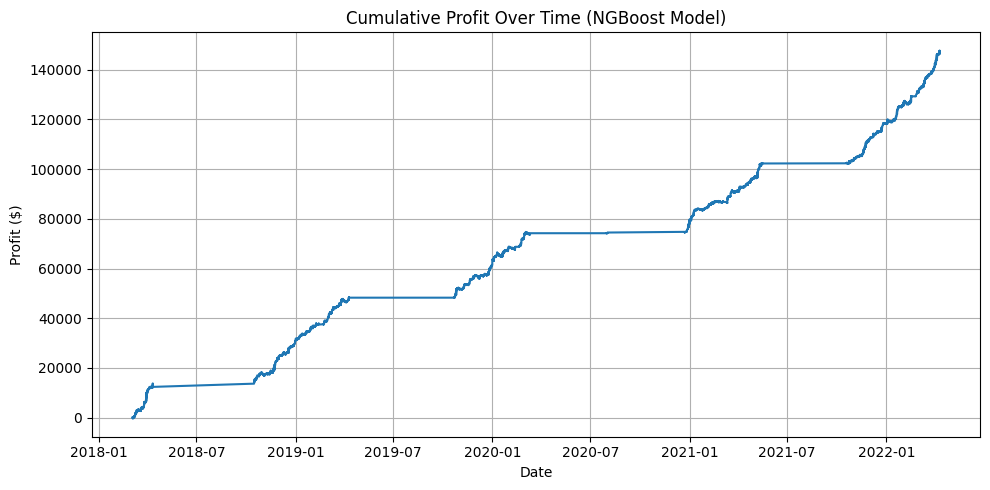

In [23]:
import pandas as pd
import numpy as np
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare data
df_model = pd.read_csv("merged_data_features_with_tiredness.csv", parse_dates=["date"])
#df_model = pd.read_csv("merged_data_features.csv", parse_dates=["date"])
df_model = df_model.sort_values("date")

# Drop rows with NaN in key columns
feature_cols = ['fg_pct_diff', 'ft_pct_diff', 'fg3_pct_diff', 'ast_diff', 'reb_diff', \
                'moneyline_diff','tiredness_diff','fg_pct_vs_opp_diff', \
                'ft_pct_vs_opp_diff', 'fg3_pct_vs_opp_diff', 'ast_vs_opp_diff', \
                'reb_vs_opp_diff', 'pts_vs_opp_diff']
target_col = 'score_diff'
df_model = df_model.dropna(subset=feature_cols + [target_col, 'spread'])

# Containers for cross-validation results
all_preds, all_actuals, all_dates = [], [], []
all_profits, all_bet_teams = [], []
all_bet_A, all_bet_B, all_spreads = [], [], []
all_pred_std = []

edge_margin = 1.5
tscv = TimeSeriesSplit(n_splits=6)

for train_idx, test_idx in tscv.split(df_model):
    train_df = df_model.iloc[train_idx].copy()
    test_df = df_model.iloc[test_idx].copy()


    ngb = NGBRegressor(Dist=Normal, Score=MLE, verbose=False,
                   n_estimators=500, random_state=42)

    ngb.fit(train_df[feature_cols], train_df[target_col])

    # Predict
    #test_df['pred_score_diff'] = ngb.predict(test_df[feature_cols])
    pred_dist = ngb.pred_dist(test_df[feature_cols])
    test_df['pred_score_diff'] = pred_dist.loc
    test_df['pred_std'] = pred_dist.scale


    # Betting logic
    test_df['bet_A'] = test_df['pred_score_diff'] > (test_df['spread'] + edge_margin)
    test_df['bet_B'] = test_df['pred_score_diff'] < (test_df['spread'] - edge_margin)
    test_df['bet_team'] = np.where(test_df['bet_A'], 'A',
                             np.where(test_df['bet_B'], 'B', 'None'))

    def bet_profit(row):
        if row['bet_team'] == 'A':
            if row['score_diff'] > row['spread']:
                return (row['teamA_moneyLine'] / 100) * 100 if row['teamA_moneyLine'] > 0 else 10000 / abs(row['teamA_moneyLine'])
            else:
                return -100
        elif row['bet_team'] == 'B':
            if row['score_diff'] < row['spread']:
                return (row['teamB_moneyLine'] / 100) * 100 if row['teamB_moneyLine'] > 0 else 10000 / abs(row['teamB_moneyLine'])
            else:
                return -100
        else:
            return 0

    test_df['profit'] = test_df.apply(bet_profit, axis=1)

    # Store fold results
    all_preds.append(test_df['pred_score_diff'])
    all_pred_std.append(test_df['pred_std'])

    all_actuals.append(test_df['score_diff'])
    all_dates.append(test_df['date'])
    all_profits.append(test_df['profit'])
    all_bet_teams.append(test_df['bet_team'])
    all_bet_A.append(test_df['bet_A'])
    all_bet_B.append(test_df['bet_B'])
    all_spreads.append(test_df['spread'])

final_df = pd.DataFrame({
    'date': pd.concat(all_dates).reset_index(drop=True),
    'pred_score_diff': pd.concat(all_preds).reset_index(drop=True),
    'pred_std': pd.concat(all_pred_std).reset_index(drop=True),
    'score_diff': pd.concat(all_actuals).reset_index(drop=True),
    'profit': pd.concat(all_profits).reset_index(drop=True),
    'bet_team': pd.concat(all_bet_teams).reset_index(drop=True),
    'bet_A': pd.concat(all_bet_A).reset_index(drop=True),
    'bet_B': pd.concat(all_bet_B).reset_index(drop=True),
    'spread': pd.concat(all_spreads).reset_index(drop=True)
})


# Evaluation
total_bets = (final_df['bet_team'] != 'None').sum()
total_profit = final_df['profit'].sum()
#rmse = mean_squared_error(final_df['score_diff'], final_df['pred_score_diff'], squared=False)
rmse = np.sqrt(mean_squared_error(final_df['score_diff'], final_df['pred_score_diff']))
roi = total_profit / (total_bets * 100) if total_bets > 0 else 0

# Save and Plot
final_df['cumulative_profit'] = final_df['profit'].cumsum()
final_df = final_df.sort_values('date')
final_df.to_csv("ngboost_model_predictions.csv", index=False)

plt.figure(figsize=(10, 5))
plt.plot(final_df['date'], final_df['cumulative_profit'])
plt.title('Cumulative Profit Over Time (NGBoost Model)')
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score
true_winner = (final_df['score_diff'] > 0).astype(int)
pred_winner = (final_df['pred_score_diff'] > 0).astype(int)
accuracy = accuracy_score(true_winner, pred_winner)
print("Win/Loss Prediction Accuracy:", round(accuracy * 100, 2), "%")

Win/Loss Prediction Accuracy: 67.29 %


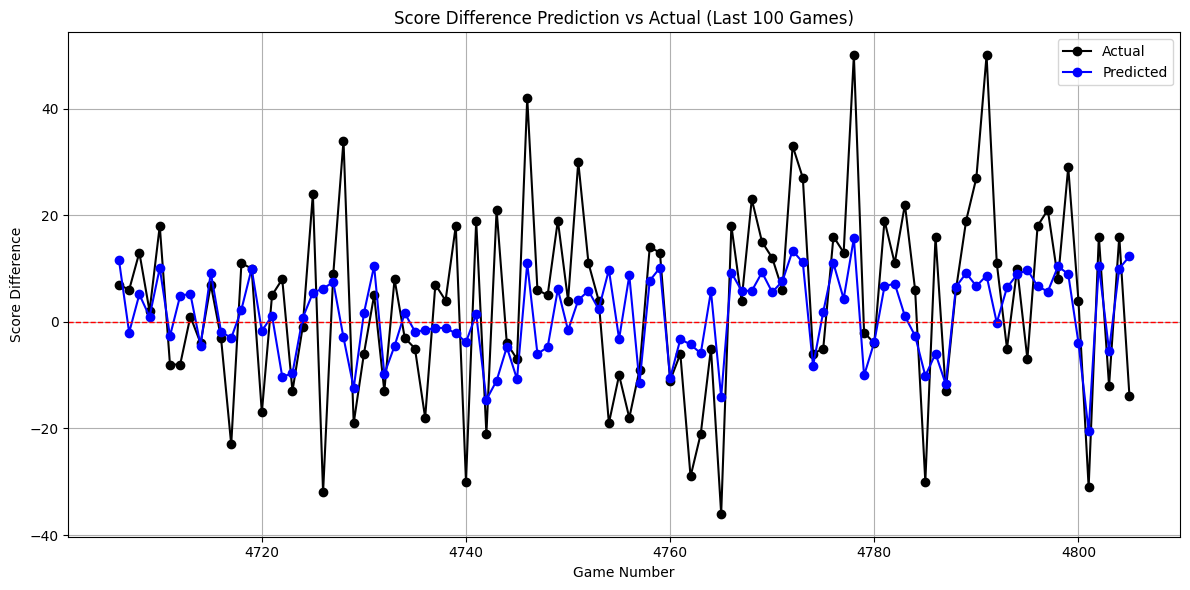

In [25]:
final_df = final_df.sort_values('date').reset_index(drop=True)
final_df['game_number'] = final_df.index 

plot_df = final_df.tail(100).copy()
plt.figure(figsize=(12, 6))

# Actual values with markers
plt.plot(
    plot_df['game_number'], 
    plot_df['score_diff'], 
    label='Actual', 
    color='black', 
    marker='o'
)

# Predicted values with markers
plt.plot(
    plot_df['game_number'], 
    plot_df['pred_score_diff'], 
    label='Predicted', 
    color='blue', 
    marker='o'
)

plt.xlabel('Game Number')
plt.ylabel('Score Difference')
plt.title('Score Difference Prediction vs Actual (Last 100 Games)')
plt.legend()
plt.grid(True)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


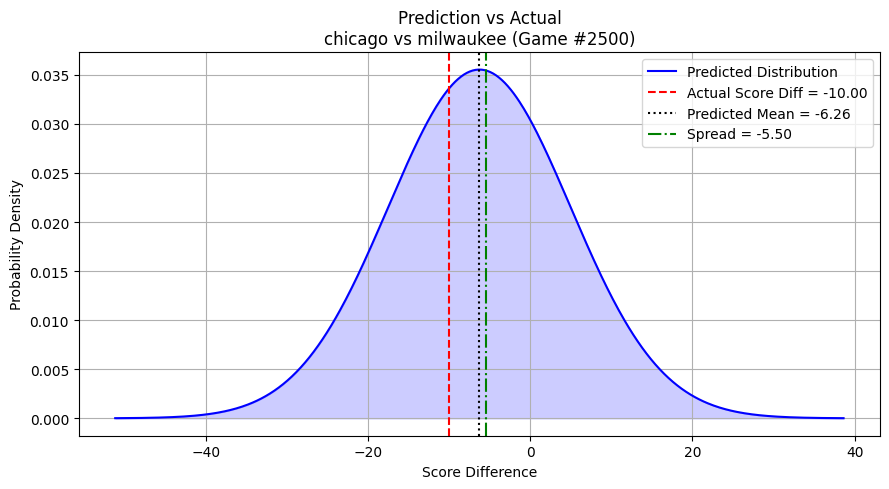

In [26]:
#distribution single match example:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

game_idx = 2500

mu = final_df.loc[game_idx, 'pred_score_diff']
sigma = final_df.loc[game_idx, 'pred_std']
actual = final_df.loc[game_idx, 'score_diff']
spread = final_df.loc[game_idx, 'spread']

x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(9, 5))
plt.plot(x, y, label='Predicted Distribution', color='blue')
plt.axvline(actual, color='red', linestyle='--', label=f'Actual Score Diff = {actual:.2f}')
plt.axvline(mu, color='black', linestyle=':', label=f'Predicted Mean = {mu:.2f}')
plt.axvline(spread, color='green', linestyle='-.', label=f'Spread = {spread:.2f}')
plt.fill_between(x, y, alpha=0.2, color='blue')

try:
    teamA = df_model.loc[game_idx, 'teamA']
    teamB = df_model.loc[game_idx, 'teamB']
    plt.title(f'Prediction vs Actual\n{teamA} vs {teamB} (Game #{game_idx})')
except:
    plt.title(f'Prediction vs Actual (Game #{game_idx})')

plt.xlabel('Score Difference')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()